In [9]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import json
import csv

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from keras.initializers import Constant
from keras.optimizers import SGD, Adam
from keras.layers import TextVectorization
from keras import Model
from keras.src.optimizers.legacy.adadelta import Adadelta
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid, StratifiedKFold

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def read_corpus(corpus_file):
    """Read in review data set and returns docs and labels"""
    documents = []
    labels = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            tokens = line.strip()
            documents.append(" ".join(tokens.split()[:-1]).strip())
            labels.append(tokens.split()[-1])
    return documents, labels

In [35]:
def get_emb_matrix(voc, emb):
    """Get embedding matrix given vocab and the embeddings"""
    num_tokens = len(voc) + 2
    word_index = dict(zip(voc, range(len(voc))))
    # Bit hacky, get embedding dimension from the word "the"
    embedding_dim = len(emb["the"])
    # Prepare embedding matrix to the correct size
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = emb.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    # Final matrix with pretrained embeddings that we can feed to embedding layer
    return embedding_matrix

In [33]:
def read_glove_vectors(filename):
  with open(filename, 'r', encoding='UTF-8') as f:
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
  return word_to_vec_map

In [45]:
X_train, y_train = read_corpus('/content/gdrive/MyDrive/University/learning_from_data/assignment_4/train.tsv')
X_val, y_val = read_corpus('/content/gdrive/MyDrive/University/learning_from_data/assignment_4/dev.tsv')
X_test, y_test = read_corpus('/content/gdrive/MyDrive/University/learning_from_data/assignment_4/test.tsv')

In [34]:
# For the sake of speed only load 50 dimensional vectors here
embeddings = read_glove_vectors('/content/gdrive/MyDrive/University/learning_from_data/assignment_4/embeddings/glove.twitter.27B.200d.txt')

In [96]:
embeddings

{'<user>': array([ 0.78704 ,  0.72151 ,  0.29148 , -0.056527,  0.31683 ,  0.47172 ,
         0.023461,  0.69568 ,  0.20782 ,  0.60985 , -0.22386 ,  0.7481  ,
        -2.6208  ,  0.20117 , -0.48104 ,  0.12897 ,  0.035239, -0.24486 ,
        -0.36088 ,  0.026686,  0.28978 , -0.10698 , -0.34621 ,  0.021053,
         0.54514 , -1.0958  , -0.274   ,  0.2233  ,  1.0827  , -0.029018,
        -0.84029 ,  0.58619 , -0.36511 ,  0.34016 ,  0.89615 ,  0.32757 ,
         0.24267 ,  0.68404 , -0.34374 ,  0.13583 , -2.2162  , -0.42537 ,
         0.46157 ,  0.88626 , -0.22014 ,  0.025599, -0.38615 ,  0.080107,
        -0.075323, -0.61461 ]),
 '.': array([ 0.68661 , -1.0772  ,  0.011114, -0.24075 , -0.3422  ,  0.64456 ,
         0.54957 ,  0.30411 , -0.54682 ,  1.4695  ,  0.43648 , -0.34223 ,
        -2.7189  ,  0.46021 ,  0.016881,  0.13953 ,  0.020913,  0.050963,
        -0.48108 , -1.0764  , -0.16807 , -0.014315, -0.55055 ,  0.67823 ,
         0.24359 , -1.3179  , -0.036348, -0.228   ,  1.0337  , -0

In [36]:
# Transform words to indices using a vectorizer
vectorizer = TextVectorization(standardize=None, output_sequence_length=50)
# Use train and dev to create vocab - could also do just train
text_ds = tf.data.Dataset.from_tensor_slices(X_train + X_dev)
vectorizer.adapt(text_ds)

In [37]:
# Dictionary mapping words to idx
voc = vectorizer.get_vocabulary()
emb_matrix = get_emb_matrix(voc, embeddings)

In [46]:
# Transform string labels to one-hot encodings
encoder = LabelBinarizer()
y_train_bin = encoder.fit_transform(y_train)  # Use encoder.classes_ to find mapping back
y_val_bin = encoder.fit_transform(y_val)

In [99]:
y_train_bin

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [47]:
# Transform input to vectorized input
X_train_vect = vectorizer(np.array([[s] for s in X_train])).numpy()
X_val_vect = vectorizer(np.array([[s] for s in X_val])).numpy()

In [101]:
def evaluate(model, X_test, Y_test, ident):
    '''Do predictions and measure accuracy on our own test set (that we split off train)'''
    # Get predictions using the trained model
    Y_pred = model.predict(X_test)
    # Finally, convert to numerical labels to get scores with sklearn
    Y_pred = np.argmax(Y_pred, axis=1)
    # If you have gold data, you can calculate accuracy
    Y_test = np.argmax(Y_test, axis=1)
    print('Accuracy on own {1} set: {0}'.format(round(accuracy_score(Y_test, Y_pred), 3), ident))
    return accuracy_score(Y_test, Y_pred)

In [100]:
def create_model_adaptive(y_train, emb_matrix, learning_rate, loss_function, optimizer, layers, activation):
  """
  This method is a more generic version of the supplied create_model
  function.

  layers: This should contain a number of keras layers which are added to the
  model in sequence. This way, this function can generate models with different
  architectures.
  """

  # Take embedding dim and size from emb_matrix
  embedding_dim = len(emb_matrix[0])
  num_tokens = len(emb_matrix)
  num_labels = len(set(y_train))

  # We pass the class to the grid search and then instantiate here so that the
  # optimizer variables are freshly initialized each time
  optimizer_initialized = optimizer()

  # Set the learning rate here to make the grid search more elegant
  optimizer_initialized.learning_rate.assign(learning_rate)

  model = Sequential()
  model.add(Embedding(num_tokens, embedding_dim, embeddings_initializer=Constant(emb_matrix),trainable=False))

  for layer in layers:
    model.add(layer)

  model.add(Dense(input_dim=embedding_dim, units=1, activation=activation, name='output'))
  model.compile(loss=loss_function, optimizer=optimizer_initialized, metrics=['accuracy'])
  return model

In [102]:
def train_model_adaptive(model, X_train, y_train, X_val, y_val, epochs, batch_size):
  """
  This method is a more generic version of the supplied train_model function.
  """
  verbose = 1
  # Early stopping: stop training when there are three consecutive epochs without improving
  # It's also possible to monitor the training loss with monitor="loss"
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
  model.fit(X_train, y_train, verbose=verbose, epochs=epochs, callbacks=[callback], batch_size=batch_size, validation_data=(X_val, y_val))
  return model

TSNE exploration

In [52]:
def plot_2d_tsne(X, y):
  tsne = TSNE(n_components=2, init='random', perplexity=30, n_iter=250, random_state=0)
  X_tsne = tsne.fit_transform(X)
  X_tsne_df = pd.DataFrame.from_records(X_tsne, columns=['X_1', 'X_2'])
  X_tsne_df['y'] = y_train
  standard_scaler = StandardScaler()
  X_tsne_df['X_1'], X_tsne_df['X_2'] = standard_scaler.fit_transform(np.array([X_tsne_df['X_1'], X_tsne_df['X_2']]).T).T
  return X_tsne_df

In [106]:
initial_lstm_layers = [
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(64),
]

initial_lstm_model = create_model_adaptive(
  y_train=y_train,
  emb_matrix=emb_matrix,
  learning_rate=0.001,
  loss_function='mse',
  activation='sigmoid',
  optimizer=Adam,
  layers=initial_lstm_layers,
)

initial_lstm_model = train_model_adaptive(
  model=initial_lstm_model,
  X_train=X_train_vect,
  y_train=y_train_bin,
  X_val=X_val_vect,
  y_val=y_val_bin,
  epochs=50,
  batch_size=256,
)

Epoch 1/50
48/48 [==============================] - 7s 34ms/step - loss: 0.2235 - accuracy: 0.6640 - val_loss: 0.2137 - val_accuracy: 0.6710
Epoch 2/50
48/48 [==============================] - 1s 13ms/step - loss: 0.1996 - accuracy: 0.7023 - val_loss: 0.1899 - val_accuracy: 0.7150
Epoch 3/50
48/48 [==============================] - 1s 16ms/step - loss: 0.1857 - accuracy: 0.7286 - val_loss: 0.1895 - val_accuracy: 0.7200
Epoch 4/50
48/48 [==============================] - 1s 15ms/step - loss: 0.1814 - accuracy: 0.7362 - val_loss: 0.1817 - val_accuracy: 0.7440
Epoch 5/50
48/48 [==============================] - 1s 16ms/step - loss: 0.1776 - accuracy: 0.7445 - val_loss: 0.1795 - val_accuracy: 0.7390
Epoch 6/50
48/48 [==============================] - 1s 17ms/step - loss: 0.1753 - accuracy: 0.7512 - val_loss: 0.1786 - val_accuracy: 0.7490
Epoch 7/50
48/48 [==============================] - 1s 11ms/step - loss: 0.1746 - accuracy: 0.7513 - val_loss: 0.1777 - val_accuracy: 0.7490
Epoch 8/50
48

In [107]:
extractor = Model(inputs=initial_lstm_model.inputs,
                        outputs=[layer.output for layer in initial_lstm_model.layers])
features = extractor(X_train_vect)

In [108]:
input = features[0]
lstm_output_1 = np.take(features[1], -1, axis=1) # Take last element her since sequences are returned
lstm_output_2 = np.take(features[2], -1, axis=1) # Take last element her since sequences are returned
lstm_output_3 = features[3]

intermediate_outputs = [
    (np.max(input, axis=1), 'Embeddings (max)'),
    (lstm_output_1, 'LSTM output (layer 1)'),
    (lstm_output_2, 'LSTM output (layer 2)'),
    (lstm_output_3, 'LSTM output (layer 3)'),
]

plot_df = pd.DataFrame({})

for X, name in intermediate_outputs:
  X_tsne_df = plot_2d_tsne(X, y_train)
  X_tsne_df['name'] = name
  plot_df = pd.concat([plot_df, X_tsne_df])

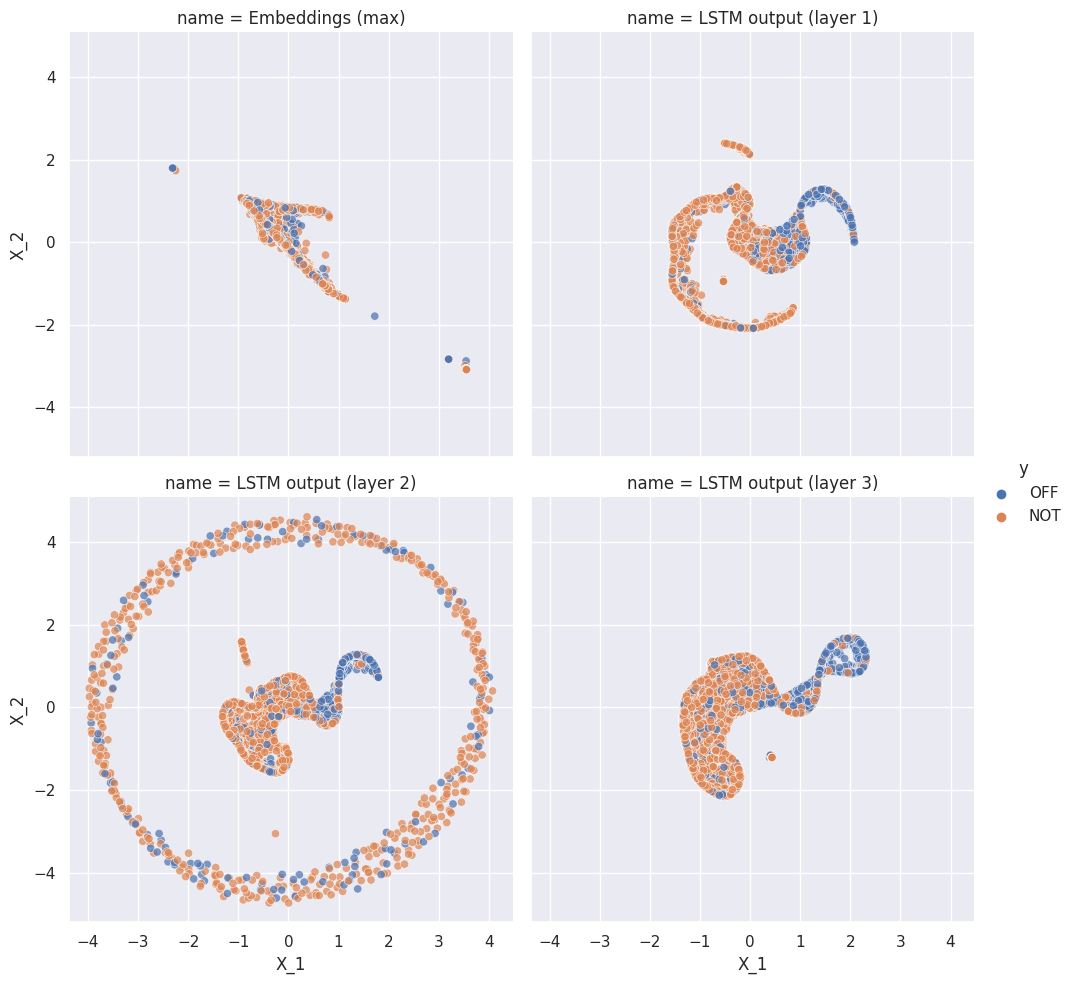

In [112]:
sns.relplot(data=plot_df, x='X_1', y='X_2', hue='y', col='name', alpha=0.7, col_wrap=2)

plt.savefig(f'/content/gdrive/MyDrive/University/learning_from_data/assignment_4/plots/manifold_{datetime.datetime.now().isoformat()}.svg')